<a href="https://colab.research.google.com/github/khchoi-physik/pbh_simulations/blob/main/nearest_neighbour_analysis_2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.special import erf
from sklearn.cluster import DBSCAN
import networkx as nx

import matplotlib.pyplot as plt
from matplotlib import cm

import glob
import os
import gc

In [2]:
def grf_2d(mean, std_dev, pixel, amplitude, k_power):
    # Generate white noise in-place
    white_noise = np.random.normal(mean, std_dev, (pixel, pixel))

    # 2D Fast Fourier transform of the white noise
    fft_white_noise = np.fft.fft2(white_noise)
    del white_noise
    gc.collect()

    # Generating FFT momentum
    kx = np.fft.fftfreq(pixel) * pixel
    ky = np.fft.fftfreq(pixel) * pixel

    # Generating FFT momentum 2D array
    kx_grid, ky_grid = np.meshgrid(kx, ky)
    del kx, ky
    gc.collect()

    # Norm of k
    k_norm = np.sqrt(kx_grid**2 + ky_grid**2)
    k_norm[0, 0] = np.inf  # Regularize divergence at k=0
    del kx_grid, ky_grid
    gc.collect()

    # Power Spectrum P_k
    power_spectrum = amplitude * (((2 * np.pi / pixel) * k_norm) ** (-k_power))
    del k_norm  # Free memory
    gc.collect()

    # Multiply the power spectrum with the transformed white noise to get the realization of the spectrum
    fourier_amplitudes_sqrt = np.sqrt(power_spectrum, out=power_spectrum) * fft_white_noise
    del power_spectrum, fft_white_noise  # Free memory
    gc.collect()

    # Perform inverse Fourier transform to obtain the Gaussian random field in the spatial domain
    gaussian_random_field = np.fft.ifft2(fourier_amplitudes_sqrt).real
    del fourier_amplitudes_sqrt  # Free memory
    gc.collect()

    return gaussian_random_field




def gaussian_to_exp(x, lam):
    mu = np.mean(x)
    sigma = np.std(x)
    xu = 0.5 * (1 + erf((x - mu) / (np.sqrt(2) * sigma)))
    return -1/lam  * np.log(1 - xu)


In [16]:
exprf = gaussian_to_exp( grf_2d(mean= 0, std_dev = 1, pixel= 2**12, amplitude = 1, k_power=2), 1)

In [17]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# k_power =1

# folder_path = '/content/gdrive/MyDrive/2023 RFSimulations/simulated_field/'
# main_path = folder_path + f'k_{k_power}'

In [18]:
# os.chdir(main_path)

# exprf_list = glob.glob('exprf*.npy')
# print(exprf_list)
# exprf = np.load(exprf_list[0])
print(exprf.shape)

(4096, 4096)


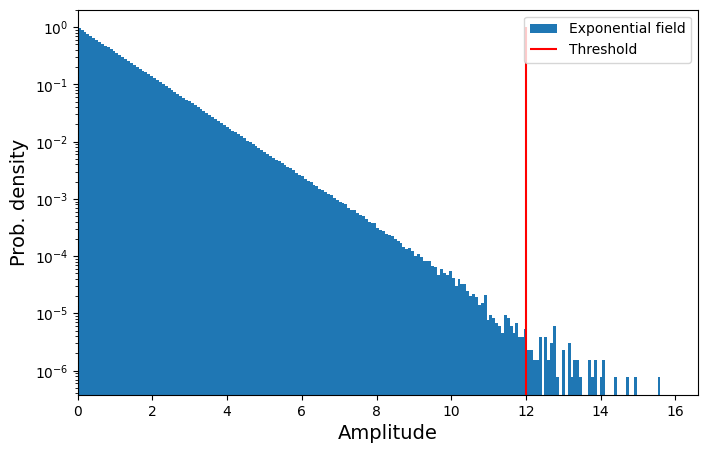

In [24]:
threshold = 12

plt.figure( figsize = (8,5))
plt.hist(exprf.flatten(), bins=201, density=True, label='Exponential field');
plt.yscale('log')
plt.xlim(0,exprf.max()+1)
plt.xlabel('Amplitude', fontsize=14)
plt.ylabel('Prob. density', fontsize=14)
plt.vlines(threshold,0,1, color='r', label='Threshold')
plt.legend()
plt.savefig('Prob_dens.pdf', bbox_inches='tight', dpi=300)
plt.show()

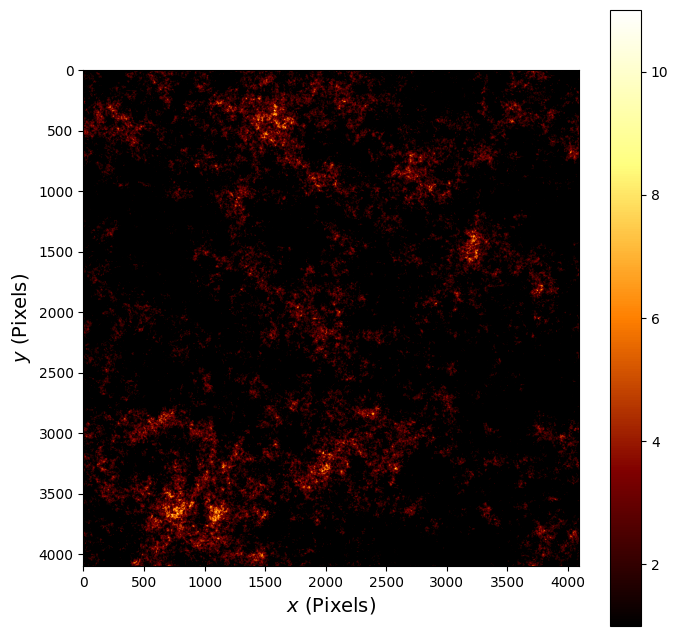

In [25]:
plt.figure( figsize = (8,8))
plt.imshow(exprf, cmap='afmhot')
plt.xlabel(f'$x$ (Pixels)',fontsize=14)
plt.ylabel(f'$y$ (Pixels)',fontsize=14)
plt.colorbar()
plt.clim(1,11)
plt.savefig('Field.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [26]:
# threshold = 11  # 2048
threshold = threshold # 8192
mask = exprf > threshold

In [27]:
pos = np.argwhere(mask)
print(pos.shape)

(64, 2)


In [28]:
eps = 100
min_samples = 2

clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(pos)

In [29]:
labels = clustering.labels_
print(labels)

[ 0  0  0  0  0  0  0  0 -1  1  1 -1 -1 -1 -1  2  2  2  2  2  2  2  2  2
  2  3  3  3  4  4  5  5  5 -1  6  7  6  6  7  6  7  7  6  7  7  7  7  7
  7  6  6  6  6  6  6  7  7  7  6  6  7  7  7 -1]


In [30]:
num_clt = len(set(labels))
cmap = cm.get_cmap('rainbow', num_clt)

print(num_clt)

9


<ipython-input-30-33e86091dd2b>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow', num_clt)


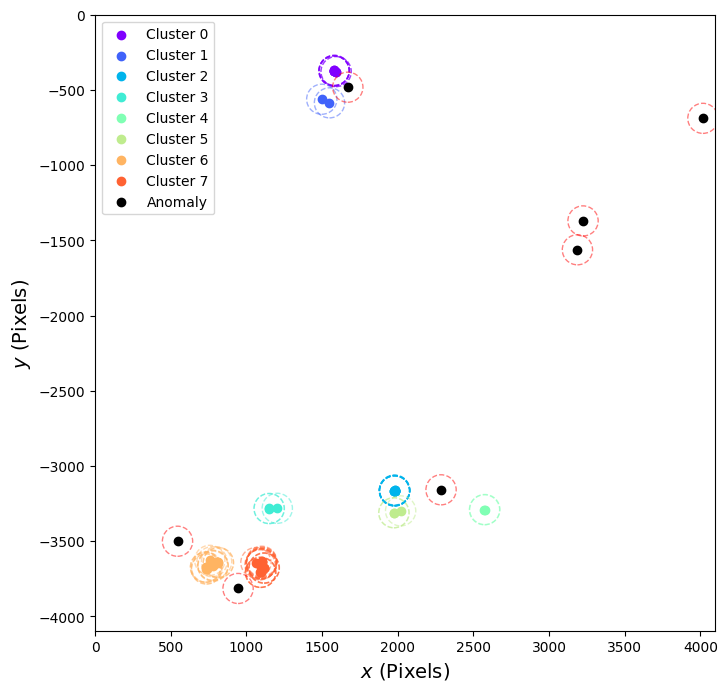

In [31]:
plt.figure( figsize = (8,8))

for ii in set(labels):
    clt_idx = np.where(labels == ii)
    clt_pos = pos[clt_idx]
    color = cmap(ii % num_clt)

    if ii == -1:
        plt.scatter( clt_pos[:,1], -clt_pos[:,0] , c='k', label='Anomaly')
    else:
        plt.scatter( clt_pos[:,1], -clt_pos[:,0] , color = color, label=f'Cluster {ii}')

    for p in clt_pos:
        circle = plt.Circle((p[1], -p[0]), eps, color = color, fill=False, linestyle='--', alpha=0.5)  # You can adjust the circle properties here
        plt.gca().add_artist(circle)


plt.xlabel(f'$x$ (Pixels)', fontsize=14)
plt.ylabel(f'$y$ (Pixels) ', fontsize=14)
plt.xlim(0,exprf.shape[0])
plt.ylim(-exprf.shape[1],0)
plt.legend()
plt.savefig('Cluster.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [32]:
# Initialize empty dictionary
clt_pos_dict = {}

# Iterate over all clustes
for ii in set(labels):

    # Find the index of the cluster
    clt_idx = np.where(labels == ii)
    # Find the coordinates of the cluster using the index
    clt_pos = pos[clt_idx]
    # Append the coordinates into the dictionary
    clt_pos_dict[ii] = clt_pos


In [33]:
l = 1 ## box size = 2L+1

# Generate offsets for the 3x3 box
offsets = np.array( [(i,j) for i in range(-l,l+1) for j in range(-l,l+1)])

# Initialize empty dictionary to store the all coordinates of the box
coordinates = {}

# Iterate over each cluster in labels, exlcuding `-1`
for ii in set(labels) - {-1}:

    # Initialize empty list for collecting coordinates in cluster `ii`
    coordinates[ii] = []

    # Iterate over the coordinates of each box center
    for coor_center in clt_pos_dict[ii]:

        # Append the coordinates for the entire box (arrays)
        coordinates[ii].append(coor_center + offsets)

    # Concatenate lists of arrays into a single array
    coordinates[ii] = np.concatenate(coordinates[ii])

    # Remove duplications
    coordinates[ii] = np.unique(coordinates[ii], axis=0)

In [34]:
# Intitialize dictionary for recording the amplitude and the total mass
amplitude_list, mass_list = {}, {}

# Iterate over clusters without "-1"
for ii in set(labels) - {-1}:

    # Collect the amplitudes in the cluster
    amplitude_list[ii] = exprf[ coordinates[ii][:,0] , coordinates[ii][:,1] ]

    # Sum to get total mass
    mass_list[ii] = np.sum(amplitude_list[ii])



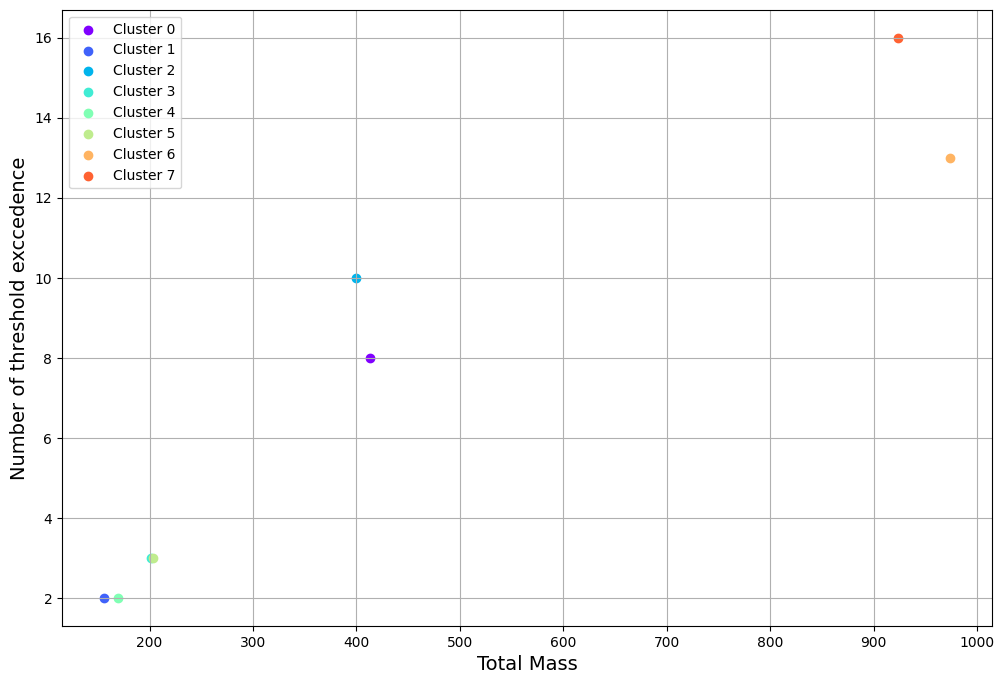

In [42]:
plt.figure( figsize = (12,8))

for ii in set(labels) - {-1}:
    color = cmap(ii % num_clt)
    plt.scatter( mass_list[ii], clt_pos_dict[ii].shape[0], label=f'Cluster {ii}',  color = color)

plt.legend()
plt.xlabel('Total Mass', fontsize=14)
plt.ylabel('Number of threshold exccedence', fontsize=14)
plt.grid()
plt.savefig('Mass_vs_Thres_ex.pdf', bbox_inches='tight', dpi=300)
plt.show()

Text(0, 0.5, 'Population')

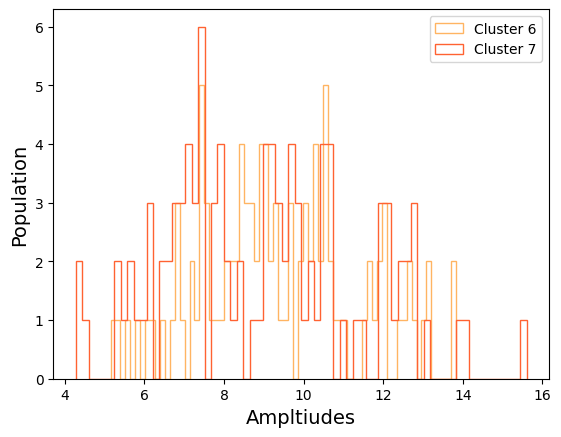

In [46]:
for ii in set(labels) - {-1}:

    if amplitude_list[ii].shape[0] > 100:
        color = cmap(ii % num_clt)
        plt.hist(amplitude_list[ii], bins=70, histtype='step', label=f'Cluster {ii}', color = color)

plt.legend()
plt.xlabel('Ampltiudes', fontsize=14)
plt.ylabel('Population', fontsize=14)

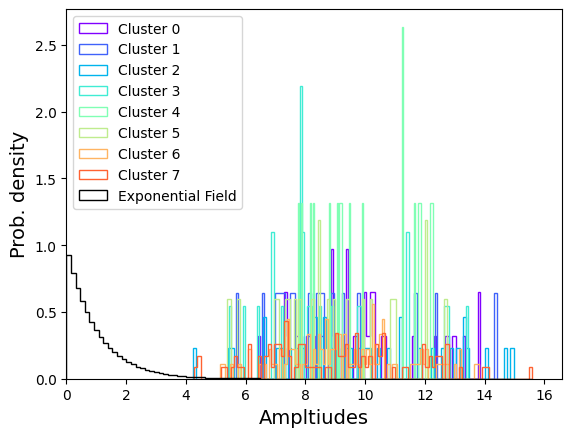

In [47]:
for ii in set(labels) - {-1}:
    color = cmap(ii % num_clt)
    plt.hist(amplitude_list[ii], bins=101, histtype='step', label=f'Cluster {ii}', color = color, density=True)

plt.hist(exprf.flatten(), bins=101, histtype='step', label='Exponential Field', color = 'k', density=True)
plt.legend()
plt.xlabel('Ampltiudes', fontsize=14)
plt.ylabel('Prob. density', fontsize=14)
plt.xlim(0,exprf.max()+1)
plt.show()

In [34]:
print(mass_list)

{0: 166.88101115238632, 1: 254.98846641337687, 2: 160.7984733293152, 3: 187.9802994727549, 4: 112.87273916244413, 5: 179.06717916836746, 6: 3915.5272928113495, 7: 908.7890272336538, 8: 159.1320668455785, 9: 129.61103600871752, 10: 171.48767545626797}


In [32]:
print(coordinates[0].shape)
print(exprf[ coordinates[0][:,0] , coordinates[0][:,1] ].shape)
print(np.sum( exprf[ coordinates[0][:,0] , coordinates[0][:,1] ] ))

(15, 2)
(15,)
166.88101115238632


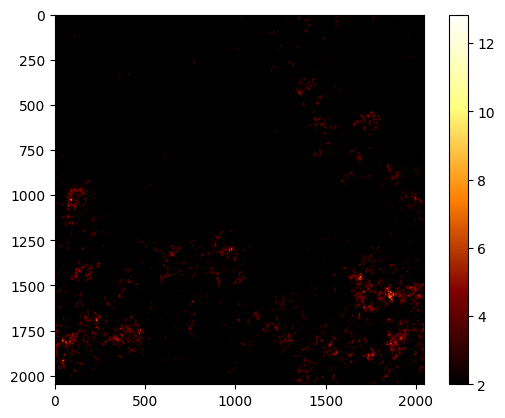

In [ ]:
plt.imshow(exprf, cmap='afmhot')
plt.colorbar()
plt.clim(2,exprf.max()-1 )
plt.show()